In [41]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage

1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.

In [42]:
image = cv2.imread('sar_1 (1).jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [43]:
def homo_median(img, mask, point, T):
    median_val = np.median(img[mask > 0])  
    if abs(median_val - img[point]) <= T:
        return True
    return False

In [44]:
def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1  
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i, j] == 0 and mask[i - r:i + r, j - r:j + r].sum() > 0:
                    if homo_fun(image, mask, (i, j), T):
                        local_mask[i, j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask
    return mask * 255

In [45]:
seed_point = (250, 250)  
r = 4  
T = 18  

In [46]:
res = region_growing(image_gray, seed_point, homo_median, r, T)

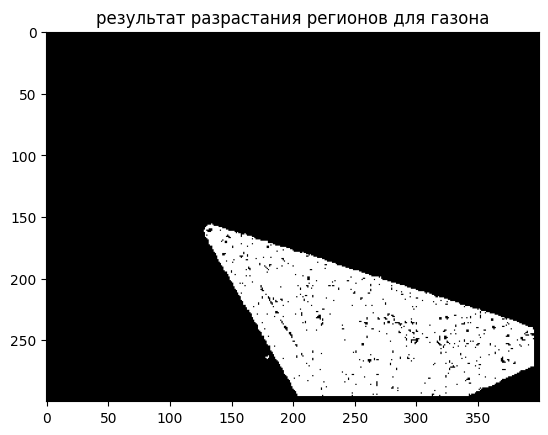

In [47]:
plt.imshow(res, cmap="gray")
plt.title("результат разрастания регионов для газона")
plt.show()

2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.

In [48]:
def homo_median(image, mask, point, T):
    if np.count_nonzero(mask > 0) == 0:
        return False
    
    median_val = np.median(image[mask > 0])
    
    if abs(median_val - image[point]) <= T:
        return True
    
    return False

In [49]:
seed_point = (158,130)
res_median = region_growing(image_gray,seed_point,homo_median,1, 25)

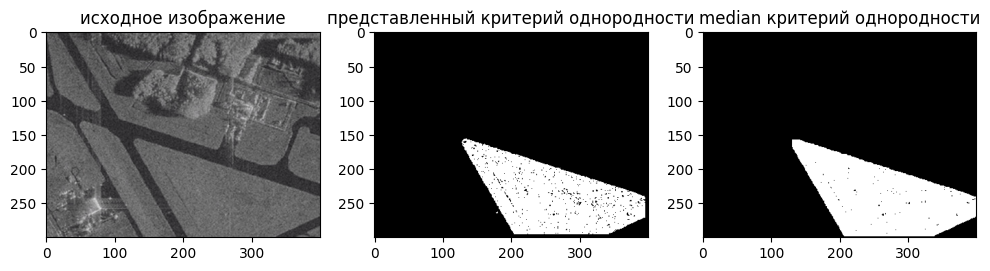

In [50]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1); plt.imshow(image, cmap='gray')
plt.title('исходное изображение')
plt.subplot(1, 3, 2); plt.imshow(res, cmap='gray')
plt.title('представленный критерий однородности')
plt.subplot(1, 3, 3); plt.imshow(res_median, cmap='gray'); 
plt.title('median критерий однородности')
plt.show()

In [51]:
from skimage.metrics import structural_similarity, mean_squared_error

(ssim, _) = structural_similarity(image_gray, res, full=True)
(ssim_median, _) = structural_similarity(image_gray, res_median, full=True)

mse = mean_squared_error(image_gray, res)
mse_median = mean_squared_error(image_gray, res_median)

print("выводы сравнения:")
print(f"res и image: SSIM = {ssim:.4f}; MSE = {mse:.4f}")
print(f"res_median и img: SSIM = {ssim_median:.4f}; MSE = {mse_median:.4f}")

выводы сравнения:
res и image: SSIM = 0.0380; MSE = 10898.9410
res_median и img: SSIM = 0.0609; MSE = 11059.8672


3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

In [52]:
image = cv2.imread('palm_1.JPG')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [53]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

In [54]:
kernel = np.ones((3, 3), np.uint8)
morph = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

In [55]:
contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros_like(binary)
for cnt in contours:
    cv2.drawContours(mask, [cnt], -1, 255, -1)

In [56]:
dist_transform = cv2.distanceTransform(morph, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

In [57]:
unknown = cv2.subtract(mask, sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

In [58]:
markers = cv2.watershed(image, markers)
image[markers == -1] = [255, 0, 0]
num_trees = len(np.unique(markers)) - 1

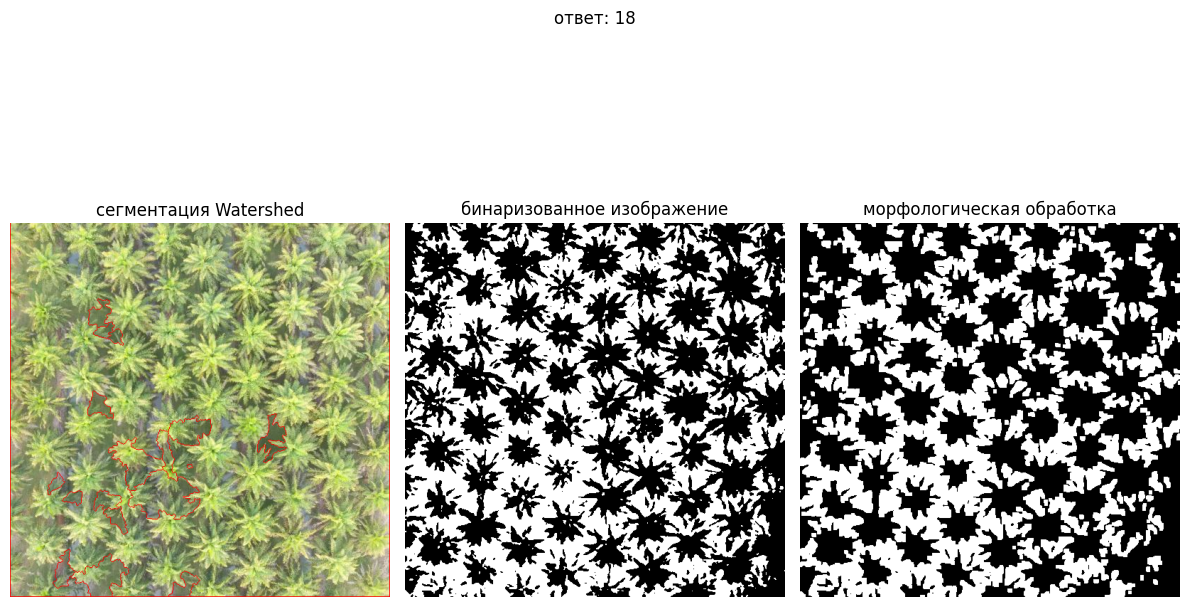

In [59]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("сегментация Watershed")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(binary, cmap='gray')
plt.title("бинаризованное изображение")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(morph, cmap='gray')
plt.title("морфологическая обработка")
plt.axis('off')
plt.suptitle(f'ответ: {num_trees}')
plt.tight_layout()
plt.show()